In [1]:
#To install packages, uncomment next lines:
#import sys
#!{sys.executable} -m pip install --upgrade wilson
#!{sys.executable} -m pip install --upgrade flavio
#!{sys.executable} -m pip install --upgrade smelli 
#!{sys.executable} -m pip install latextable
#!{sys.executable} -m pip install tabulate
import cmath
from math import e
import smelli, wilson
import matplotlib.pyplot as plt
import numpy as np
import inspect
import seaborn
import time
import matplotlib.mlab as ml
import pickle
from scipy.stats.distributions import chi2
from tqdm.notebook import tqdm as log_progress
from scipy.interpolate import griddata
from scipy.optimize import minimize
from IPython.display import display
from tabulate import tabulate
import matplotlib.ticker as ticker

# Hack implemented here to not have to edit Wilson sourcecode
# Their new method
def m2Lambda_to_vMh2_new(m2, Lambda, C):
    """Function to numerically determine the  physical Higgs VEV and mass
    given the parameters of the Higgs potential."""
    Cphi = C['phi'].real
    Ckin = C['phiBox'].real - C['phiD'].real / 4
    if abs(Cphi) < 1e-16:
        v2 = 2 * m2 / Lambda
    else:
        sqrt_arg = Lambda**2 - 12 * Cphi * m2
        if not sqrt_arg >= 0:
            raise ValueError("'Lambda**2 - 12 * Cphi * m2' must be positive.")
        v2 = ( Lambda - sqrt(sqrt_arg) )/( 3 * Cphi )
    Mh2 = v2 / (1 - 2 * Ckin * v2) * (Lambda - 3 * Cphi * v2)

    return {'v': sqrt(v2), 'Mh2': Mh2}

wilson.run.smeft.smpar.m2Lambda_to_vMh2 = m2Lambda_to_vMh2_new

def vMh2_to_m2Lambda_new(v, Mh2, C):
    """Function to numerically determine the parameters of the Higgs potential
    given the physical Higgs VEV and mass."""
    #print('mH2= ', Mh2, 'v= ', v )
    v2 = v**2
    Cphi = C['phi'].real
    Ckin = C['phiBox'].real - C['phiD'].real / 4
    Ckin_factor = ( 1 + Ckin * v2 )**2
    #Lambda = ( Mh2 + 3 * Cphi * v2**2 * Ckin_factor ) / ( v2 * Ckin_factor )
    Lambda = Mh2 / v2 - 2 * Ckin * Mh2 + 3 * Cphi * v2
    m2 = Lambda * v2 / 2 - 3/4 * Cphi * v2**2
    #print('m2= ', m2, 'Lambda= ', Lambda )
    return {'m2': m2, 'Lambda': Lambda}

wilson.run.smeft.smpar.vMh2_to_m2Lambda = vMh2_to_m2Lambda_new
# Here a little convenience function that gives back a dict with all likes for given inputs directly

# This calculates the likelihood and all stuff we want for cphi, cphiD and cphibox in that order given as a list
def smpar_new(C):
    """Get the running effective SM parameters."""
    m2 = C['m2'].real
    Lambda = C['Lambda'].real
    vMh2 = m2Lambda_to_vMh2(m2, Lambda, C)
    v = vMh2['v']
    Mh2 = vMh2['Mh2']
    GF = 1 / (sqrt(2) * v**2)  # TODO
    eps = C['phiWB'].real * (v**2)
    gb = (C['g'] / (1 - C['phiW'].real * (v**2))).real
    gpb = (C['gp'] / (1 - C['phiB'].real * (v**2))).real
    gsb = (C['gs'] / (1 - C['phiG'].real * (v**2))).real
    MW = gb * v / 2
    ZG0 = 1 + C['phiD'].real * (v**2) / 4
    MZ = (sqrt(gb**2 + gpb**2) / 2 * v
          * (1 + eps * gb * gpb / (gb**2 + gpb**2)) * ZG0)
    Mnup = -(v**2) * C['llphiphi']
    Mep = v / sqrt(2) * (C['Ge'] - C['ephi'] * (v**2) / 2)
    Mup = v / sqrt(2) * (C['Gu'] - C['uphi'] * (v**2) / 2)
    Mdp = v / sqrt(2) * (C['Gd'] - C['dphi'] * (v**2) / 2)
    UeL, Me, UeR = ckmutil.diag.msvd(Mep)
    UuL, Mu, UuR = ckmutil.diag.msvd(Mup)
    UdL, Md, UdR = ckmutil.diag.msvd(Mdp)
    UnuL, Mnu = ckmutil.diag.mtakfac(Mnup)
    eb = (gb * gpb / sqrt(gb**2 + gpb**2) *
          (1 - eps * gb * gpb / (gb**2 + gpb**2)))
    K = UuL.conj().T @ UdL
    # U = UeL.conj().T @ UnuL
    sm = {}
    sm['GF'] = GF
    sm['alpha_e'] = eb**2 / (4 * pi)
    sm['alpha_s'] = gsb**2 / (4 * pi)
    sm['Vub'] = abs(K[0, 2])
    sm['Vcb'] = abs(K[1, 2])
    sm['Vus'] = abs(K[0, 1])
    sm['delta'] = phase(-K[0, 0] * K[0, 2].conj()
                        / (K[1, 0] * K[1, 2].conj()))
    # sm['U'] = Uu
    sm['m_W'] = MW
    sm['m_Z'] = MZ
    sm['m_h'] = sqrt(abs(Mh2))
    sm['m_u'] = Mu[0]
    sm['m_c'] = Mu[1]
    sm['m_t'] = Mu[2]
    sm['m_d'] = Md[0]
    sm['m_s'] = Md[1]
    sm['m_b'] = Md[2]
    sm['m_e'] = Me[0]
    sm['m_mu'] = Me[1]
    sm['m_tau'] = Me[2]
    return  {k: v.real for k, v in sm.items()}

wilson.run.smeft.smpar.smpar = smpar_new

# Angles for VdL. We are using the ansatz that these are equal to the measured
# central values of the CKM matrix except for theta_23 which we allow to float.
# From PDG 2020 except s23
s12 = 0.22650
s13 = 0.00361
delta = 1.196
t12 = np.arcsin(s12)
t13 = np.arcsin(s13)
c12 = np.cos(t12)
c13 = np.cos(t13)
m13 = np.array([
    [                      c13,      0,   s13*e**complex(0, -delta)],
    [                        0,      1,                           0],
    [-s13*e**complex(0, delta),      0,                         c13]
])
m12 = np.array([
    [ c12,  s12,   0],
    [-s12,  c12,   0],
    [   0,    0,   1]
])
mmm = m13 @ m12
l_xi = []
# This is a convenience function that returns the indices with an off-set
# it helps with checking and makes the writing easier
def L_xi(i,j): 
    return l_xi[i-1][j-1]
    #return "L_xi"+str(i-1)+str(j-1)

lq1_nonredundant_indices = [2211,2212,2213,2222,2223,2233,3311,3312,3313,3322,3323,3333]

qq1_nonredundant_indices = [1111,1112,1113,1122,1123,1133,1212,1213,1221,1222,1223,1231,1232,1233,1313,1322,1323,1331,1332,1333,2222,2223,2233,2323,2332,2333,3333]

def fill_qq1(alpha):
   qq1_3333_unmixed = -(1/72) * alpha 
   listqq1 = {}
   for i in range(1,4):
       for j in range(1,4):
           for k in range(1,4):
               for l in range(1,4): # Loops over the four indices
                   # The indices as an int
                   intIndex = 1000*i + 100*j + 10*k + l 
                   # Combination from commuting currents
                   intpermIndex = 1000*k + 100*l + 10*i + j 
                   # h.c
                   inthcIndex1 = 1000*l + 100*k + 10*j + i 
                   # h.c + commuting currents
                   inthcIndex2 = 1000*j + 100*i + 10*l + k 
                   # List of equivalent permutations
                   permlist = [intIndex,intpermIndex, inthcIndex1 , inthcIndex2] 
                   # Here I check which combination is the one in the Smelli basis
                   match = [m for m in qq1_nonredundant_indices if m in permlist][0] 
                   name = 'qq1_' + str(match)
                   factor = 2
                   if i==k and j==l:
                        factor = 1
                   # Here I add the contribution to the non-redundant op.
                   if name in listqq1:
                       listqq1[name] += factor * qq1_3333_unmixed * L_xi(i,j) * L_xi(k,l)
                   else:
                       listqq1[name] = factor * qq1_3333_unmixed * L_xi(i,j) * L_xi(k,l)
   return listqq1

VdL = []   
# This function is for setting the input: alpha=gz'^2/MZ'^2, theta=theta_sb input too
# The down quarks are in their mass basis for these unhatted operators, whereas the up
# quarks will be CKM-mixed
# This function is for setting the input: alpha=gz'^2/MZ'^2, theta=theta_sb input too
# The down quarks are in their mass basis for these unhatted operators, whereas the up
# quarks will be CKM-mixed
def calcinputlist(alpha, theta_23):
        s23 = np.sin(theta_23)
        c23 = np.cos(theta_23)
        m23 = np.array([
            [1,    0,   0],
            [0,  c23, s23],
            [0, -s23, c23]
        ])
        VdL = m23 @ mmm
        # matrix of couplings to down quarks: see (18) in 1905.10327
        l_xi.clear()
        for i in range(0, 3):
            l_xi.append([np.conj(VdL[2, i]) * VdL[2, k] for k in range(0, 3)])# Make central-valued CKM matrix: from PDG 2020      
        inputlist_qq1 = fill_qq1(alpha)   
        # Checked by BCA 1/3/21
        inputlist_explicit = {            
            # LL operators
            'll_2222' : -(1/8)  * alpha,
            'lq1_2211': (1/12)  * alpha * l_xi[0][0],
            'lq1_2212': (1/12)  * alpha * (l_xi[0][1] + l_xi[1][0]),
            'lq1_2213': (1/12)  * alpha * (l_xi[0][2] + l_xi[2][0]),
            'lq1_2222': (1/12)  * alpha * l_xi[1][1],
            'lq1_2223': (1/12)  * alpha * (l_xi[1][2] + l_xi[2][1]),
            'lq1_2233': (1/12)  * alpha * l_xi[2][2], 
            # RR operators
            'ee_3333': -(1/2)  * alpha,
            'uu_3333': -(2/9)  * alpha,
            'dd_3333': -(1/18) * alpha,
            'eu_3333':  (2/3)  * alpha,
            'ed_3333': -(1/3)  * alpha,
            'ud1_3333': (2/9)  * alpha,
            # LR operators
            'le_2233': -(1/2)  * alpha,
            'lu_2233':  (1/3)  * alpha,
            'ld_2233': -(1/6)  * alpha,
            'qe_1133':  (1/6)   * alpha * l_xi[0][0] ,
            'qe_1233':  (1/6)   * alpha * (l_xi[0][1] + l_xi[1][0]),
            'qe_1333':  (1/6)   * alpha * (l_xi[0][2] + l_xi[2][0]),
            'qe_2233':  (1/6)   * alpha * l_xi[1][1],
            'qe_2333':  (1/6)   * alpha * (l_xi[1][2] + l_xi[2][1]),
            'qe_3333':  (1/6)   * alpha * l_xi[2][2],            
            'qu1_1133':-(1/9)   * alpha * l_xi[0][0] ,
            'qu1_1233':-(1/9)   * alpha * (l_xi[0][1] + l_xi[1][0]),
            'qu1_1333':-(1/9)   * alpha * (l_xi[0][2] + l_xi[2][0]),
            'qu1_2233':-(1/9)   * alpha * l_xi[1][1],
            'qu1_2333':-(1/9)   * alpha * (l_xi[1][2] + l_xi[2][1]),
            'qu1_3333':-(1/9)   * alpha * l_xi[2][2],
            'qd1_1133': (1/18)  * alpha * l_xi[0][0],
            'qd1_1233': (1/18)  * alpha * (l_xi[0][1] + l_xi[1][0]),
            'qd1_1333': (1/18)  * alpha * (l_xi[0][2] + l_xi[2][0]),
            'qd1_2233': (1/18)  * alpha * l_xi[1][1],
            'qd1_2333': (1/18)  * alpha * (l_xi[1][2] + l_xi[2][1]),
            'qd1_3333': (1/18)  * alpha * l_xi[2][2],
            # Higgs + two fermions NB WE MUST CHECK THE SIGNS OF THESE CONTRIBUTIONS!!!
                    # LL operators
            'phil1_22': +(1/4)  * alpha,
            'phiq1_11': -(1/12)  * alpha * l_xi[0][0],
            'phiq1_12': -(1/12)  * alpha * (l_xi[0][1] + l_xi[1][0]),
            'phiq1_13': -(1/12)  * alpha * (l_xi[0][2] + l_xi[2][0]),
            'phiq1_22': -(1/12)  * alpha * l_xi[1][1],
            'phiq1_23': -(1/12)  * alpha * (l_xi[1][2] + l_xi[2][1]),
            'phiq1_33': -(1/12)  * alpha * l_xi[2][2],           
            'phie_33':   (1/2)  * alpha,
            'phiu_33':  -(1/3)  * alpha,
            'phid_33':   (1/6)  * alpha,
            'phiD':     -(1/2)  * alpha,
            'phiBox':   -(1/8)  * alpha
        } 
        return {**inputlist_explicit, **inputlist_qq1}

# This function takes a 'pull SM' from the obstable and squares it, adding a sign: + if the fit is *better* than the SM
def pull_to_chisq(x):
    if (x > 0):
        ans = -x**2
    else:
        ans = x**2
    return ans

# This protects against breakdown in the calculation:
# saves nan's if the point doesn't work (tends to happen at large
# coupling/mixing)
def calc_likelihoods(MZp, gzp, theta):
    Q = MZp
    alpha = gzp**2 / MZp**2
    glp = gl.parameter_point(calcinputlist(alpha, theta), scale=Q)
    try:
        dictionary = glp.log_likelihood_dict()
     
    except Exception as E:
        print(E)
        keys = ['fast_likelihood_quarks.yaml',
                'likelihood_ewpt.yaml',
                'likelihood_lfu_fcnc.yaml',
                'global']
        dictionary = {}
        for key in keys:
            dictionary[key] = np.nan
    dictionary['gzp'] = gzp
    dictionary['MZp'] = MZp
    dictionary['theta'] = theta
    return(dictionary)

def minus_lnL(pars1):
    # MZp = pars1[0]
    gzp = pars1[0]
    theta23 = pars1[1]
    dictionary = calc_likelihoods(MZp, gzp, theta23)
    return -dictionary['global']

# The full likelihood is equivalent to:
gl = smelli.GlobalLikelihood(include_likelihoods=
        {
        'fast_likelihood_quarks.yaml',
        'likelihood_ewpt.yaml',
        'likelihood_lfu_fcnc.yaml'
         })

In [3]:
# here we calculate some likes for plotting in 2-d: first, gzp vs theta
data_for_plot1 = []
# resolution for 2d scans: best to make it i*10+1 because it includes 
# the endpoints
resolution_y = 101
resolution_x = 81
MZp = 3000

theta_range = np.linspace(0., -0.5, num=resolution_y)
gzp_range   = np.linspace(0.,  2.0, num=resolution_x)
for theta in log_progress(theta_range):
    for gzp in gzp_range:
        data_for_plot1.append(calc_likelihoods(MZp, gzp, theta))

# write output to datafile
with open('tfhm_2d.dat', 'wb') as filehandle:
    pickle.dump(data_for_plot1, filehandle)

The extraction of CKM elements failed. Too large NP effects?
The extraction of CKM elements failed. Too large NP effects?
The extraction of CKM elements failed. Too large NP effects?
The extraction of CKM elements failed. Too large NP effects?
The extraction of CKM elements failed. Too large NP effects?
The extraction of CKM elements failed. Too large NP effects?
The extraction of CKM elements failed. Too large NP effects?
The extraction of CKM elements failed. Too large NP effects?
The extraction of CKM elements failed. Too large NP effects?
The extraction of CKM elements failed. Too large NP effects?
The extraction of CKM elements failed. Too large NP effects?
The extraction of CKM elements failed. Too large NP effects?
The extraction of CKM elements failed. Too large NP effects?
The extraction of CKM elements failed. Too large NP effects?
The extraction of CKM elements failed. Too large NP effects?
The extraction of CKM elements failed. Too large NP effects?
The extraction of CKM el

The extraction of CKM elements failed. Too large NP effects?
The extraction of CKM elements failed. Too large NP effects?
The extraction of CKM elements failed. Too large NP effects?
The extraction of CKM elements failed. Too large NP effects?
The extraction of CKM elements failed. Too large NP effects?
The extraction of CKM elements failed. Too large NP effects?
The extraction of CKM elements failed. Too large NP effects?
The extraction of CKM elements failed. Too large NP effects?
The extraction of CKM elements failed. Too large NP effects?
The extraction of CKM elements failed. Too large NP effects?
The extraction of CKM elements failed. Too large NP effects?
The extraction of CKM elements failed. Too large NP effects?
The extraction of CKM elements failed. Too large NP effects?
The extraction of CKM elements failed. Too large NP effects?
The extraction of CKM elements failed. Too large NP effects?
The extraction of CKM elements failed. Too large NP effects?
The extraction of CKM el

The extraction of CKM elements failed. Too large NP effects?
The extraction of CKM elements failed. Too large NP effects?
The extraction of CKM elements failed. Too large NP effects?
The extraction of CKM elements failed. Too large NP effects?
The extraction of CKM elements failed. Too large NP effects?
The extraction of CKM elements failed. Too large NP effects?
The extraction of CKM elements failed. Too large NP effects?
The extraction of CKM elements failed. Too large NP effects?
The extraction of CKM elements failed. Too large NP effects?
The extraction of CKM elements failed. Too large NP effects?
The extraction of CKM elements failed. Too large NP effects?
The extraction of CKM elements failed. Too large NP effects?
The extraction of CKM elements failed. Too large NP effects?
The extraction of CKM elements failed. Too large NP effects?
The extraction of CKM elements failed. Too large NP effects?
The extraction of CKM elements failed. Too large NP effects?
The extraction of CKM el

The extraction of CKM elements failed. Too large NP effects?
The extraction of CKM elements failed. Too large NP effects?
The extraction of CKM elements failed. Too large NP effects?
The extraction of CKM elements failed. Too large NP effects?
The extraction of CKM elements failed. Too large NP effects?
The extraction of CKM elements failed. Too large NP effects?
The extraction of CKM elements failed. Too large NP effects?
The extraction of CKM elements failed. Too large NP effects?
The extraction of CKM elements failed. Too large NP effects?
The extraction of CKM elements failed. Too large NP effects?
The extraction of CKM elements failed. Too large NP effects?
The extraction of CKM elements failed. Too large NP effects?
The extraction of CKM elements failed. Too large NP effects?
The extraction of CKM elements failed. Too large NP effects?
The extraction of CKM elements failed. Too large NP effects?
The extraction of CKM elements failed. Too large NP effects?
The extraction of CKM el

The extraction of CKM elements failed. Too large NP effects?
The extraction of CKM elements failed. Too large NP effects?
The extraction of CKM elements failed. Too large NP effects?
The extraction of CKM elements failed. Too large NP effects?
The extraction of CKM elements failed. Too large NP effects?
The extraction of CKM elements failed. Too large NP effects?
The extraction of CKM elements failed. Too large NP effects?
The extraction of CKM elements failed. Too large NP effects?
The extraction of CKM elements failed. Too large NP effects?
The extraction of CKM elements failed. Too large NP effects?
The extraction of CKM elements failed. Too large NP effects?
The extraction of CKM elements failed. Too large NP effects?
The extraction of CKM elements failed. Too large NP effects?
The extraction of CKM elements failed. Too large NP effects?
The extraction of CKM elements failed. Too large NP effects?
The extraction of CKM elements failed. Too large NP effects?
The extraction of CKM el

In [7]:
MZp = 3000
pars_start = [gzp_gf, theta_gf]
res = minimize(minus_lnL, pars_start, method='nelder-mead',
               options={'fatol': 1e-1, 'disp': True, 'maxfev': 200})

KeyboardInterrupt: 

In [7]:
print(res)
gzp_gf     = res.x[0]
theta_gf   = res.x[1]
max_dchi2 = -2 * res.fun

 final_simplex: (array([[ 0.42551091, -0.14501005],
       [ 0.42559125, -0.14495629],
       [ 0.42544908, -0.14505874]]), array([-21.31500863, -21.31500631, -21.31500301]))
           fun: -21.31500863005739
       message: 'Optimization terminated successfully.'
          nfev: 46
           nit: 24
        status: 0
       success: True
             x: array([ 0.42551091, -0.14501005])


Max[chi^2_SM-chi^2](gzp=0.42551091, theta=-0.14501005)=42.63001726011478
Max[chi^2_SM(EWPT)-chi^2(EWPT)]=0.6160337474211275
Max[chi^2_SM(RK*)-chi^2(RK*)]=15.007313010796295
Max[chi^2_SM(NCBA)-chi^2(NCBA)]=30.521686700251223
[0.2   0.225 0.25  0.275 0.3   0.325 0.35  0.375 0.4   0.425 0.45  0.475
 0.5   0.525 0.55  0.575 0.6   0.625 0.65  0.675 0.7   0.725 0.75  0.775
 0.8   0.825 0.85  0.875 0.9   0.925 0.95  0.975 1.    1.025 1.05  1.075
 1.1   1.125 1.15  1.175 1.2   1.225 1.25  1.275 1.3   1.325 1.35  1.375
 1.4   1.425 1.45  1.475 1.5   1.525 1.55  1.575 1.6   1.625 1.65  1.675
 1.7   1.725 1.75  1.775 1.8   1.825 1.85  1.875 1.9   1.925 1.95  1.975
 2.   ]
[-0.3429534  -0.27923092 -0.23360665 -0.19917839 -0.17228926 -0.15075741
 -0.1331796  -0.11860481 -0.10636288 -0.09596695 -0.08705455 -0.07935021
 -0.07264098 -0.06675976 -0.06157369 -0.05697596 -0.05287977 -0.04921397
 -0.04591973 -0.04294803 -0.04025777 -0.03781423 -0.03558794 -0.03355371
 -0.03168996 -0.02997805 -0.02840183 -

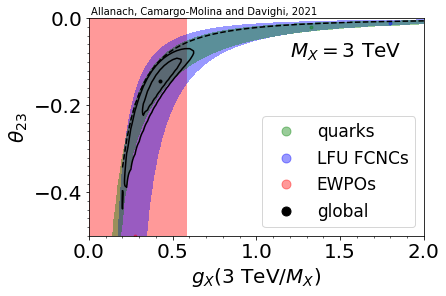

In [30]:
# Read in plot 1 data
with open('tfhm_2d.dat', 'rb') as filehandle:
    data_for_plot1 = pickle.load(filehandle)
# Identify best-fit point
gzp_for_plot1  =  [data['gzp']      for data in data_for_plot1]
theta_for_plot1 = [data['theta']   for data in data_for_plot1]
dchi2_for_plot1 = [2*data['global']   for data in data_for_plot1]
max_D_old   = max(dchi2_for_plot1)
pos        = dchi2_for_plot1.index(max_D_old)
max_dchi2   = 2 * 21.31500863005739
gzp_gf     = 0.42551091
theta_gf   = -0.14501005
print('Max[chi^2_SM-chi^2](gzp=' + str(gzp_gf) + ', theta=' + str(theta_gf) + ')=' + str(max_dchi2))
ewpt_dchi2_for_plot1 = [2*data['likelihood_ewpt.yaml'] for data in data_for_plot1]
fcnc_dchi2_for_plot1 = [2*data['likelihood_lfu_fcnc.yaml'] for data in data_for_plot1]
ncba_dchi2_for_plot1 = [2*data['fast_likelihood_quarks.yaml'] for data in data_for_plot1] 
# EWPT
max_dchi2_ewpt = max(ewpt_dchi2_for_plot1)
pos = ewpt_dchi2_for_plot1.index(max_dchi2_ewpt)
gzp_ewpt = gzp_for_plot1[pos]
theta_ewpt = theta_for_plot1[pos]
print('Max[chi^2_SM(EWPT)-chi^2(EWPT)]=' + str(max_dchi2_ewpt))
# RK(*)
max_dchi2_fcnc = max(fcnc_dchi2_for_plot1)
pos = fcnc_dchi2_for_plot1.index(max_dchi2_fcnc)
gzp_fcnc = gzp_for_plot1[pos]
theta_fcnc = theta_for_plot1[pos]
print('Max[chi^2_SM(RK*)-chi^2(RK*)]=' + str(max_dchi2_fcnc))
# Other NCBAs
max_dchi2_ncba = max(ncba_dchi2_for_plot1)
pos = ncba_dchi2_for_plot1.index(max_dchi2_ncba)
gzp_ncba = gzp_for_plot1[pos]
theta_ncba = theta_for_plot1[pos]
print('Max[chi^2_SM(NCBA)-chi^2(NCBA)]=' + str(max_dchi2_ncba))
# Plot 70%/95% contours for global fit
x = np.array(gzp_for_plot1)
y = np.array(theta_for_plot1)
z = np.array(dchi2_for_plot1)
z2 = np.array(ewpt_dchi2_for_plot1)
z3 = np.array(fcnc_dchi2_for_plot1)
z4 = np.array(ncba_dchi2_for_plot1)
cols = np.unique(x).shape[0]
X = x.reshape(-1, cols)
Y = y.reshape(-1, cols)
Z = z.reshape(-1, cols)
Z2 = z2.reshape(-1, cols)
Z3 = z3.reshape(-1, cols)
Z4 = z4.reshape(-1, cols)
x1 = np.unique(x)[8:]
print(x1)
F = 0.5*np.arcsin(-0.00563 * 9 / ((x1)**2+0.2*x1))
print(F)

# make plot
plt.rcParams.update({'font.size': 20}) 
fig,ax = plt.subplots()
plt.rcParams['contour.negative_linestyle'] = 'solid'
alpha_level = 0.4
#contourf_ = ax.contourf(X, Y, Z, [max_dchi2-5.99, max_dchi2], colors='k',   alpha=alpha_level)
contourf2_ = ax.contourf(X, Y, Z2, [max_dchi2_ewpt-5.99, max_dchi2_ewpt], colors='r',  alpha=alpha_level)
contourf3_ = ax.contourf(X, Y, Z3, [max_dchi2_fcnc-5.99, max_dchi2_fcnc], colors='b',  alpha=alpha_level)
contourf4_ = ax.contourf(X, Y, Z4, [max_dchi2_ncba-5.99, max_dchi2_ncba], colors='g',  alpha=alpha_level)
#contour2_  = ax.contour (X, Y, Z2, [max_dchi2_ewpt-5.99, max_dchi2_ewpt-2.41], colors='r', alpha=alpha_level)
#contour3_  = ax.contour (X, Y, Z3, [max_dchi2_fcnc-5.99, max_dchi2_fcnc-2.41], colors='b', alpha=alpha_level)
#contour4_  = ax.contour (X, Y, Z4, [max_dchi2_ncba-5.99, max_dchi2_ncba-2.41], colors='g', alpha=alpha_level)
contour_  = ax.contour (X, Y, Z, [max_dchi2-5.99, max_dchi2-2.41], colors='k')
plt.rcParams.update({'font.size': 16}) 
plt.plot(gzp_ncba, theta_ncba, 'g.',label='quarks',alpha=alpha_level)
plt.plot(gzp_fcnc, theta_fcnc, 'b.',label='LFU FCNCs',alpha=alpha_level)
plt.plot(gzp_ewpt, theta_ewpt, 'r.',label='EWPOs',alpha=alpha_level)
plt.plot(gzp_gf, theta_gf,'k.', label='global')
plt.rcParams.update({'font.size': 20}) 
#cbar = fig.colorbar(contourf_,label='$\chi^2_{SM}-\chi^2$')
plt.xlabel(r'$g_{X}$(3 TeV/$M_{X}$)') 
plt.ylabel(r'$\theta_{23}$') 
#plt.title('$M_{X}$=' + str(MZp / 1000.) + ' TeV')
plt.legend(loc='lower right',markerscale=3, fontsize=17)
plt.gca().yaxis.set_minor_locator(plt.MultipleLocator(0.02))
plt.gca().xaxis.set_minor_locator(plt.MultipleLocator(0.1))
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.5))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax.plot(x1,F,'k--')
plt.text(1.2, -0.09, '$M_{X}=3$ TeV', fontsize=20)
plt.text(0.01, 0.008, "Allanach, Camargo-Molina and Davighi, 2021", fontsize=10)
plt.savefig('tfhm_plot1.pdf', bbox_inches = "tight")

In [20]:
# TFHMeg good fit point
MZp_gf   = 3000
theta = theta_gf
gzp = gzp_gf
MZp = MZp_gf
# end of input parameters
alpha = gzp**2 / MZp**2
# set high precision for single points
wilson.Wilson.set_default_option('smeft_accuracy', 'integrate')
# first, find the Standard Model chi^2
glp_sm = gl.parameter_point(calcinputlist(0., 0.), scale=MZp)
glp_sm.log_likelihood_global()
print('--- Standard Model ---')
display(glp_sm.log_likelihood_dict())
display(glp_sm.chi2_dict())
chi2_sm=glp_sm.chi2_dict()['global']
display(glp_sm.likelihood.number_observations_dict())
sm_obs=glp_sm.obstable()
def get_pull(ln_sm, observ):
    return ln_sm.obstable().at[observ, 'pull exp.'] * np.sign(ln_sm.obstable().at[observ, 'theory'] - ln_sm.obstable().at[observ, 'experiment'])
def obs_list(ln_sm):
    return {
    '$R_K(1,6)$': get_pull(ln_sm, ('<Rmue>(B+->Kll)', 1.1, 6.0)),
    '$R_{K^*}(0.045,1.1)$': get_pull(ln_sm, ('<Rmue>(B0->K*ll)', 0.045, 1.1)),
    '$R_{K^*}(1.1,6)$': get_pull(ln_sm, ('<Rmue>(B0->K*ll)', 1.1, 6.0)),
    '$P_5^{\prime}(4,6)$': get_pull(ln_sm, ('<P5p>(B0->K*mumu)', 4, 6)),
    'BR($B_s$->$\mu\mu$)': get_pull(ln_sm, 'BR(Bs->mumu)'), 
    '$\Delta m_s$': get_pull(ln_sm, 'DeltaM_s'),
    'BR($B_s$->$\phi\mu\mu$)(1,6)': get_pull(ln_sm, ('<dBR/dq2>(Bs->phimumu)', 1.0, 6.0)),
    'BR($\Lambda_b$->$\Lambda\mu\mu$)(15,20)': get_pull(ln_sm, ('<dBR/dq2>(Lambdab->Lambdamumu)', 15, 20))
    }
SM_int=obs_list(glp_sm)
def write_line(f, ln, like_str, like, num_fit_params):
    chisq = ln.chi2_dict()[like]
    nobs  = ln.likelihood.number_observations_dict()[like]
    dof   = nobs - num_fit_params
    pval  = chi2.sf(chisq, dof)
    f.write(like_str + ' & ' + '{:.1f}'.format(chisq) + ' & ' 
        + '{:d}'.format(nobs) + ' & '
            + f'{pval:.2}'.lstrip('0') + r'  \\') 
    return pval
def print_model(file_name, ln, num_fit_params):
    f = open(file_name, 'w')
    write_line(f, ln, 'quarks', 'fast_likelihood_quarks.yaml', num_fit_params)
    f.write('\n')
    write_line(f, ln, 'LFU FCNCs', 'likelihood_lfu_fcnc.yaml', num_fit_params)
    f.write('\n')
    write_line(f, ln, 'EWPOs', 'likelihood_ewpt.yaml', num_fit_params)
    f.write(r' \hline' + '\n')
    pval = write_line(f, ln, 'global', 'global', num_fit_params)
    f.write('\n')
    f.close()
    return pval
pval_sm = print_model('sm_fit.tex', glp_sm, 0)
print('--- TFHM, gzp=' + str(gzp) + ', MZp=' + str(MZp/1000) + ' TeV, theta_23=' + str(theta) + ' ---')
start_time = time.time()
glp = gl.parameter_point(calcinputlist(alpha, theta), scale=MZp)
glp.log_likelihood_global()
print("--- %s seconds to run one point ---" % (time.time() - start_time))
# lnL - lnLSM. If its >0, you are fitting better than SM
display(glp.log_likelihood_dict())
display(glp.chi2_dict())
TFHM_chi2 = glp.chi2_dict()['global']
display(glp.likelihood.number_observations_dict())
DTFHM_int = obs_list(glp)
pval_tfhm = print_model('tfhm_fit.tex', glp, 2)
g = open("y3inp.tex", "w")
g.write('\def\SMpval{{' + f'{pval_sm:.2g}'.lstrip('0') + '}}')
g.write('\n')
g.write('\def\TFHMpval{{' +f'{pval_tfhm:.2g}'.lstrip('0') + '}}')
g.write('\n')
g.write(f'\def\TFHMgzp{{{gzp_gf:.3}}}')
g.write('\n')
g.write(f'\def\TFHMtheta{{{theta_gf:.3}}}')
g.write('\n')
g.write(f'\def\TFHMchi2{{{TFHM_chi2:.1f}}}')
g.write('\n')
g.write(f'\def\SMchi2{{{chi2_sm:.1f}}}')
g.write('\n')
g.close()
# wilson.Wilson.set_default_option('smeft_accuracy', 'leadinglog')

--- Standard Model ---


{'fast_likelihood_quarks.yaml': 0.0,
 'likelihood_ewpt.yaml': 0.0,
 'likelihood_lfu_fcnc.yaml': 0.0,
 'global': 0.0}

{'fast_likelihood_quarks.yaml': 221.226739332767,
 'likelihood_ewpt.yaml': 35.742155907172716,
 'likelihood_lfu_fcnc.yaml': 35.267613721609486,
 'global': 292.23650896154925}

{'fast_likelihood_quarks.yaml': 167,
 'likelihood_ewpt.yaml': 31,
 'likelihood_lfu_fcnc.yaml': 21,
 'global': 219}

--- TFHM, gzp=0.42551091, MZp=3.0 TeV, theta_23=-0.14501005 ---
--- 17.01348614692688 seconds to run one point ---


{'fast_likelihood_quarks.yaml': 14.48488901988469,
 'likelihood_ewpt.yaml': -0.15284910344350777,
 'likelihood_lfu_fcnc.yaml': 7.124556572105481,
 'global': 21.456596488546666}

{'fast_likelihood_quarks.yaml': 192.25696129299763,
 'likelihood_ewpt.yaml': 36.04785411405973,
 'likelihood_lfu_fcnc.yaml': 21.018500577398523,
 'global': 249.32331598445592}

{'fast_likelihood_quarks.yaml': 167,
 'likelihood_ewpt.yaml': 31,
 'likelihood_lfu_fcnc.yaml': 21,
 'global': 219}

In [4]:
# Which observables fit well or badly?
print('SM')
sm_obs = sm_obs.sort_values(by=['pull exp.'])
display(sm_obs[np.abs(sm_obs['pull SM']) > 1.0] )
sm_obs['my pull']=(sm_obs['theory']-sm_obs['experiment'])/np.sqrt(sm_obs['exp. unc.'].astype(np.float64)**2+sm_obs['th. unc.'].astype(np.float64)**2)
print('Particular observables of interest')
display(sm_obs.filter(like='BR(Bs->mumu', axis=0), sm_obs.filter(like='DeltaM_s',axis=0),sm_obs.filter(like='m_W', axis=0),
        sm_obs.filter(like='AFB(Z->bb)', axis=0))
print('Y3 model')
Obstable = glp.obstable() 
Obstable = Obstable.sort_values(by=['pull exp.'])
print('Observables fitting better than SM at the top (pull SM<0), worst at the bottom (pull SM>0)')
display(Obstable[np.abs(Obstable['pull SM']) > 1.0] )
Obstable['my pull']=(Obstable['theory']-Obstable['experiment'])/np.sqrt(Obstable['exp. unc.'].astype(np.float64)**2+Obstable['th. unc.'].astype(np.float64)**2)
print('Particular observables of interest')
display(Obstable.filter(like='BR(Bs->mumu', axis=0),Obstable.filter(like='DeltaM_s',axis=0),Obstable.filter(like='m_W', axis=0),
        Obstable.filter(like='AFB(Z->bb)', axis=0))

SM


Empty DataFrame
Columns: [th. unc., experiment, exp. unc., theory, pull exp., pull SM]
Index: []

Particular observables of interest


th. unc.   experiment    exp. unc.       theory pull exp.  \
BR(Bs->mumu)  1.47249e-10  2.71478e-09  3.56951e-10  3.66668e-09   2.46523   

             pull SM  my pull  
BR(Bs->mumu)       0  2.46523

th. unc.   experiment   exp. unc.       theory pull exp. pull SM  \
DeltaM_s  7.39095e-13  1.16876e-11  1.4063e-14  1.24946e-11   1.09164       0   

          my pull  
DeltaM_s  1.09164

th. unc. experiment  exp. unc.   theory pull exp. pull SM  my pull
m_W        0    80.3795  0.0121018  80.3587   1.72032       0 -1.72032

th. unc. experiment exp. unc.   theory pull exp. pull SM  my pull
AFB(Z->bb)        0     0.0992    0.0016  0.10307   2.41878       0  2.41878

Y3 model
Observables fitting better than SM at the top (pull SM<0), worst at the bottom (pull SM>0)


th. unc.   experiment  \
(<dBR/dq2>(B+->Kmumu), 2.0, 3.0)          5.98471e-09  2.82168e-08   
(<dBR/dq2>(B+->Kmumu), 15.0, 22.0)        1.64935e-09  1.21127e-08   
(<dBR/dq2>(B0->K*mumu), 2, 4.3)           6.78906e-09  3.54108e-08   
BR(Bs->mumu)                              1.47249e-10  2.71478e-09   
S_psiK                                      0.0726553     0.679174   
(<dBR/dq2>(B0->K*mumu), 2.5, 4.0)         6.80578e-09  3.31298e-08   
m_W                                                 0      80.3795   
(<dBR/dq2>(B+->Kmumu), 0, 2)              6.10863e-09  2.53398e-08   
(<dBR/dq2>(B+->Kmumu), 3.0, 4.0)          5.90371e-09  2.53893e-08   
(<dBR/dq2>(B0->K*mumu), 4.0, 6.0)         7.53336e-09  3.54348e-08   
(<Rmue>(B+->Kll), 1.1, 6.0)                         0         0.85   
(<dBR/dq2>(B0->K*mumu), 15.0, 19.0)       6.29856e-09   4.3612e-08   
(<dBR/dq2>(B0->K*mumu), 4.3, 6)           7.61564e-09  3.41445e-08   
(<dBR/dq2>(Bs->phimumu), 15.0, 19.0)      4.57421e-09   4.0552e-08   
(<dBR/dq2>(B0->Kmumu), 15.0, 22.0)        1.52188e-09  9.55827e-09   
(<dBR/dq2>(B0->K*mumu), 1.1, 2.5)         6.76279e-09  3.26725e-08   
(<dBR/dq2>(B+->Kmumu), 5.0, 6.0)          5.74353e-09  2.31326e-08   
(<dBR/dq2>(B+->Kmumu), 1.1, 2.0)          6.06601e-09  2.32731e-08   
(<dBR/dq2>(B0->Kmumu), 2.0, 4.0)          5.51827e-09   1.9177e-08   
(<dBR/dq2>(B+->Kmumu), 4.0, 5.0)          5.82433e-09  2.21455e-08   
(<dBR/dq2>(B+->K*mumu), 15.0, 19.0)       6.82081e-09  4.01019e-08   
(<P5p>(B0->K*mumu), 1.1, 2.5)               0.0818077      0.36602   
(<dBR/dq2>(B0->Kmumu), 4.0, 6.0)          5.36959e-09  1.77249e-08   
(<FL>(B0->K*mumu), 1.1, 2.5)                0.0443308     0.656236   
BR(KL->mumu)                              1.23987e-09  6.83746e-09   
(<dBR/dq2>(B+->K*mumu), 4.0, 6.0)         8.13545e-09   2.6179e-08   
A(Z->tautau)                                        0       0.1433   
(<Rmue>(B0->K*ll), 1.1, 6.0)                        0     0.681356   
eps_K                                     0.000216446   0.00222808   
A(Z->ee)                                            0     0.151321   
R_mu                                                0      20.7842   
(<Rmue>(B0->K*ll), 0.045, 1.1)                      0     0.652542   
(<dBR/dq2>(Lambdab->Lambdamumu), 15, 20)  7.62215e-09  1.18441e-07   
(<dBR/dq2>(Bs->phimumu), 1.0, 6.0)        6.56856e-09  2.55611e-08   
AFB(Z->bb)                                          0       0.0992   
DeltaM_s                                  7.39095e-13  1.16876e-11   

                                            exp. unc.       theory  pull exp.  \
(<dBR/dq2>(B+->Kmumu), 2.0, 3.0)          2.11073e-09  2.85186e-08  0.0475638   
(<dBR/dq2>(B+->Kmumu), 15.0, 22.0)        7.11516e-10   1.2276e-08  0.0909596   
(<dBR/dq2>(B0->K*mumu), 2, 4.3)           4.65569e-09  3.62313e-08  0.0996744   
BR(Bs->mumu)                              3.56951e-10  2.79837e-09   0.216474   
S_psiK                                        0.01973     0.704684   0.338845   
(<dBR/dq2>(B0->K*mumu), 2.5, 4.0)         4.03886e-09  3.60092e-08   0.363843   
m_W                                         0.0121018      80.3747   0.394978   
(<dBR/dq2>(B+->Kmumu), 0, 2)              4.06606e-09  2.86896e-08   0.456494   
(<dBR/dq2>(B+->Kmumu), 3.0, 4.0)          1.96937e-09  2.83776e-08   0.480156   
(<dBR/dq2>(B0->K*mumu), 4.0, 6.0)         3.68468e-09  3.97813e-08    0.51829   
(<Rmue>(B+->Kll), 1.1, 6.0)                 0.0463161     0.870001   0.537018   
(<dBR/dq2>(B0->K*mumu), 15.0, 19.0)       3.64276e-09  4.78773e-08   0.586197   
(<dBR/dq2>(B0->K*mumu), 4.3, 6)             5.848e-09   4.0194e-08   0.630034   
(<dBR/dq2>(Bs->phimumu), 15.0, 19.0)      5.09419e-09  4.49617e-08    0.64408   
(<dBR/dq2>(B0->Kmumu), 15.0, 22.0)        1.65103e-09  1.13091e-08   0.779744   
(<dBR/dq2>(B0->K*mumu), 1.1, 2.5)         4.05066e-09  3.89543e-08    0.79687   
(<dBR/dq2>(B+->Kmumu), 5.0, 6.0)            1.869e-09  2.80236e-08   0.809777

Particular observables of interest


th. unc.   experiment    exp. unc.       theory pull exp.  \
BR(Bs->mumu)  1.47249e-10  2.71478e-09  3.56951e-10  2.79837e-09  0.216474   

             pull SM   my pull  
BR(Bs->mumu) -2.4557  0.216474

th. unc.   experiment   exp. unc.       theory pull exp.  \
DeltaM_s  7.39095e-13  1.16876e-11  1.4063e-14  1.38483e-11   2.92289   

          pull SM  my pull  
DeltaM_s  2.71138  2.92289

th. unc. experiment  exp. unc.   theory pull exp.  pull SM   my pull
m_W        0    80.3795  0.0121018  80.3747  0.394978 -1.67436 -0.394978

th. unc. experiment exp. unc.   theory pull exp.  pull SM  my pull
AFB(Z->bb)        0     0.0992    0.0016  0.10359   2.74352  1.29475  2.74352

{'$R_K(1,6)$': 3.227435826405594,
 '$R_{K^*}(0.045,1.1)$': 2.3867104743882925,
 '$R_{K^*}(1.1,6)$': 2.545915270092816,
 '$P_5^{\\prime}(4,6)$': -2.8759533155276764,
 'BR($B_s$->$\\mu\\mu$)': 2.376540738163379,
 '$\\Delta m_s$': 1.0910644932968752,
 'BR($B_s$->$\\phi\\mu\\mu$)(1,6)': 3.75371924531743,
 'BR($\\Lambda_b$->$\\Lambda\\mu\\mu$)(15,20)': -1.7122580318989673}

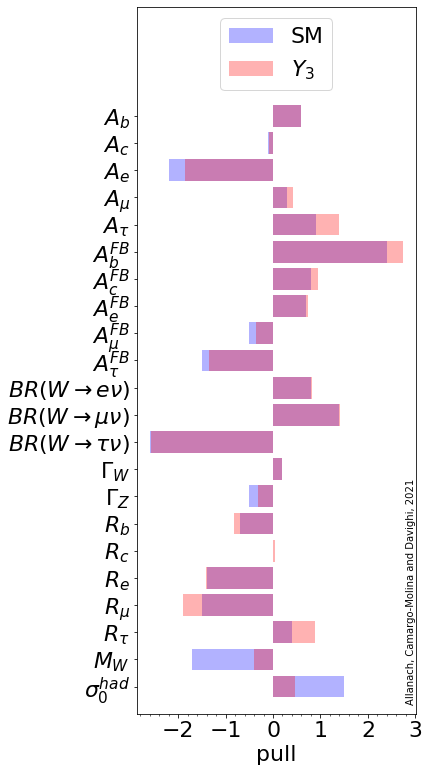

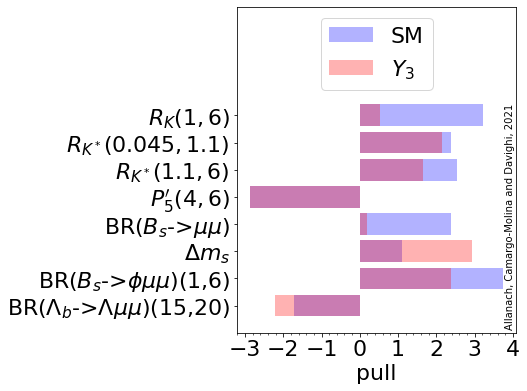

In [28]:
#glp.obstable().at['DeltaM_s','pull SM']
SM_ewpo={'$A_b$': 0.6, '$A_c$': -0.1, '$A_e$': -2.2, '$A_\mu$': 0.3, r'$A_\tau$': 0.9, '$A_b^{FB}$': 2.4, '$A_c^{FB}$': 0.8, 
         '$A_e^{FB}$': 0.7, '$A_\mu^{FB}$': -0.5, r'$A_\tau^{FB}$': -1.5, r'$BR(W\rightarrow e\nu)$': 0.8, r'$BR(W\rightarrow\mu\nu)$': 1.4, r'$BR(W\rightarrow \tau\nu)$': -2.6,
        '$\Gamma_W$': 0.2, '$\Gamma_Z$': -0.5, '$R_b$': -0.7, '$R_c$': 0.01, '$R_e$': -1.4, '$R_\mu$': -1.5, 
        r'$R_\tau$': 0.4, '$M_W$': -1.7, '$\sigma_0^{had}$': 1.5}
TFHM_ewpo={'$A_b$': Obstable.at['A(Z->bb)', 'my pull'], 
           '$A_c$': Obstable.at['A(Z->cc)', 'my pull'], 
           '$A_e$': Obstable.at['A(Z->ee)', 'my pull'], 
           '$A_\mu$': Obstable.at['A(Z->mumu)', 'my pull'], 
           '$A_T$': Obstable.at['A(Z->tautau)', 'my pull'], 
           '$A_b^{FB}$': Obstable.at['AFB(Z->bb)', 'my pull'], 
           '$A_c^{FB}$': Obstable.at['AFB(Z->cc)', 'my pull'], 
           '$A_e^{FB}$': Obstable.at['AFB(Z->ee)', 'my pull'], 
           '$A_\mu^{FB}$': Obstable.at['AFB(Z->mumu)', 'my pull'], 
           '$A_T^{FB}$': Obstable.at['AFB(Z->tautau)', 'my pull'], 
           'BR(W->e nu)': Obstable.at['BR(W->enu)', 'my pull'], 
           'BR(W->$\mu$nu)':Obstable.at['BR(W->munu)', 'my pull'],
           'BR(W->tau nu)': Obstable.at['BR(W->taunu)', 'my pull'],
           '$\Gamma_W$': Obstable.at['GammaW', 'my pull'], 
           '$\Gamma_Z$': Obstable.at['GammaZ', 'my pull'], 
           '$R_b$': Obstable.at['R_b', 'my pull'], 
           '$R_c$': Obstable.at['R_c', 'my pull'], 
           '$R_e$': Obstable.at['R_e', 'my pull'], 
           '$R_\mu$': Obstable.at['R_mu', 'my pull'], 
           '$R_T$': Obstable.at['R_tau', 'my pull'], 
           '$M_W$': Obstable.at['m_W', 'my pull'], 
           '$\sigma_0^{had}$': Obstable.at['sigma_had', 'my pull']}
plt.rcParams.update({'font.size': 22})
y_pos = np.arange(0, -len(SM_ewpo), -1)
fig = plt.figure(figsize = (5, 13))
ax = plt.subplot(1, 1, 1)
ax.barh(y_pos, SM_ewpo.values(), alpha=0.3, color='b', label='SM')
ax.barh(y_pos, TFHM_ewpo.values(), alpha=0.3, color='r', label='$Y_3$')
ax.set_yticks(y_pos)
ax.set_ylim([-22, 4])
ax.set_yticklabels(SM_ewpo.keys())
plt.xlabel('pull')
ax.xaxis.set_minor_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.legend(loc='upper center')
ax.text(2.8, -21.6, "Allanach, Camargo-Molina and Davighi, 2021", fontsize=10, rotation=90)
plt.savefig('tfhm_ewpo.pdf',  bbox_inches = "tight")
y_pos = np.arange(0, -len(SM_int), -1)
fig2 = plt.figure(figsize = (5, 6))
ax2 = plt.subplot(1, 1, 1)
ax2.barh(y_pos, SM_int.values(), alpha=0.3, color='b', label='SM')
ax2.barh(y_pos, DTFHM_int.values(), alpha=0.3, color='r', label='$Y_3$')
ax2.set_yticks(y_pos)
ax2.set_ylim([-8, 4])
ax2.set_yticklabels(SM_int.keys())
plt.xlabel('pull')
ax2.xaxis.set_minor_locator(plt.MultipleLocator(0.2))
ax2.xaxis.set_major_locator(plt.MultipleLocator(1))
ax2.legend(loc='upper center')
ax2.text(3.8, -7.8, "Allanach, Camargo-Molina and Davighi, 2021", fontsize=10, rotation=90)
plt.savefig('tfhm_int.pdf', bbox_inches = "tight")
display(SM_int)

In [12]:
# here we calculate some likelihoods for 1d plotting
data_for_gzp   = []
data_for_theta = []
data_for_MZp   = []
MZp = MZp_gf
theta = theta_gf

resolution = 51

# plot vs gzp
gzp_range   = np.linspace(0.,  1.2, num=resolution)
for gzp in log_progress(gzp_range):
    data_for_gzp.append(calc_likelihoods(MZp, gzp, theta))
gzp = gzp_gf
    
resolution = 31
# plot vs theta
theta_range = np.linspace(0,  -0.3, num=resolution)
for theta in log_progress(theta_range):
        data_for_theta.append(calc_likelihoods(MZp, gzp, theta))
theta = theta_gf
      
resolution = 11
# plot vs MZp
MZp_range   = np.linspace(2000,  10000, num=resolution)
for MZp in log_progress(MZp_range):
        gzp = gzp_gf * MZp / 3000
        data_for_MZp.append(calc_likelihoods(MZp, gzp, theta))
MZp = MZp_gf
gzp = gzp_gf
        
# save data
with open('tfhm_1d.dat', 'wb') as filehandle:
    pickle.dump(data_for_gzp, filehandle)
    pickle.dump(data_for_theta, filehandle)
    pickle.dump(data_for_MZp, filehandle)

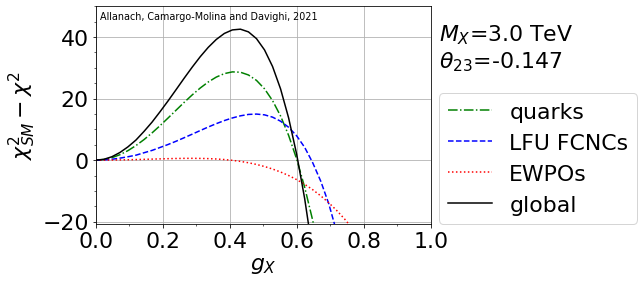

In [19]:
# Making 1d plots 
with open('tfhm_1d.dat', 'rb') as filehandle:
    data_for_gzp = pickle.load(filehandle)
    data_for_theta = pickle.load(filehandle)
    data_for_mzp = pickle.load(filehandle)
plt.rcParams.update({'font.size': 22})
gzp_gf     = 0.41836132
theta_gf   = -0.14740343
# Plot vs gzp
gforplot     = [data['gzp']                         for data in data_for_gzp]
dchi2        = [2 * data['global']                      for data in data_for_gzp]
lfu_dchi2    = [2 * data['likelihood_lfu_fcnc.yaml']    for data in data_for_gzp]
quarks_dchi2 = [2 * data['fast_likelihood_quarks.yaml'] for data in data_for_gzp]
ewpt_dchi2   = [2 * data['likelihood_ewpt.yaml']        for data in data_for_gzp]
fig, ax = plt.subplots()
ax.set_xlabel('$g_{X}$')
ax.set_ylabel('$\chi^2_{SM}-\chi^2$')
ax.plot(gforplot, quarks_dchi2, 'g-.', label='quarks')
ax.plot(gforplot, lfu_dchi2, 'b--', label='LFU FCNCs')
ax.plot(gforplot, ewpt_dchi2, 'r:', label='EWPOs')
ax.plot(gforplot, dchi2, 'k-', label='global')
ax.legend(loc=[1.025,0])
ax.grid(True)
ax.set_xlim([0, 1.0])
ax.set_ylim([-20.7, 50])
ax.yaxis.set_major_locator(plt.MultipleLocator(20))
ax.yaxis.set_minor_locator(plt.MultipleLocator(5))
ax.xaxis.set_minor_locator(plt.MultipleLocator(0.1))
ax.text(1.025, 30, r'$M_{X}$=' + str(data_for_gzp[0]['MZp']/1000) + ' TeV\n' + r'$\theta_{23}$=' + f'{theta_gf:.3g}')
ax.text(0.013, 46, "Allanach, Camargo-Molina and Davighi, 2021", fontsize=9.6)
fig.savefig('tfhm_gzp.pdf', bbox_inches = "tight")

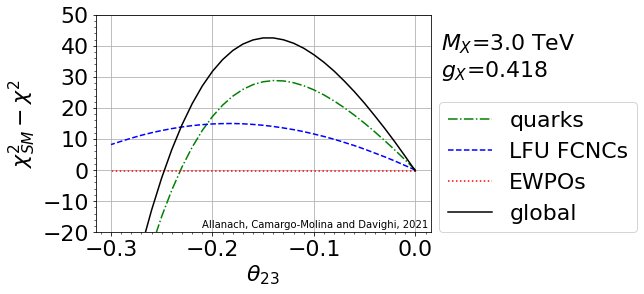

In [21]:
# Plot vs theta
thetaforplot = [data['theta']                           for data in data_for_theta]
dchi2        = [2 * data['global']                      for data in data_for_theta]
lfu_dchi2    = [2 * data['likelihood_lfu_fcnc.yaml']    for data in data_for_theta]
quarks_dchi2 = [2 * data['fast_likelihood_quarks.yaml'] for data in data_for_theta]
ewpt_dchi2   = [2 * data['likelihood_ewpt.yaml']        for data in data_for_theta]
fig2, ax2 = plt.subplots()
ax2.set_ylabel('$\chi^2_{SM}-\chi^2$')
ax2.set_xlabel(r'$\theta_{23}$') 
ax2.plot(thetaforplot, quarks_dchi2, 'g-.', label='quarks')
ax2.plot(thetaforplot, lfu_dchi2, 'b--', label='LFU FCNCs')
ax2.plot(thetaforplot, ewpt_dchi2, 'r:', label='EWPOs')
ax2.plot(thetaforplot, dchi2, 'k', label='global')
ax2.legend(loc=[1.025,0]) 
ax2.grid(True) 
#plt.gca().set_xlim([0,0.4])
ax2.set_ylim([-20, 50])
ax2.yaxis.set_major_locator(plt.MultipleLocator(10))
ax2.yaxis.set_minor_locator(plt.MultipleLocator(2))
ax2.xaxis.set_minor_locator(plt.MultipleLocator(0.01))
ax2.text(0.025, 30, r'$M_{X}$=' + str(data_for_theta[0]['MZp'] / 1000) + ' TeV\n$g_{X}$=' + f'{gzp_gf:.3g}')
ax2.text(-0.21, -18.5, "Allanach, Camargo-Molina and Davighi, 2021", fontsize=10)
fig2.savefig('tfhm_theta.pdf', bbox_inches = "tight")

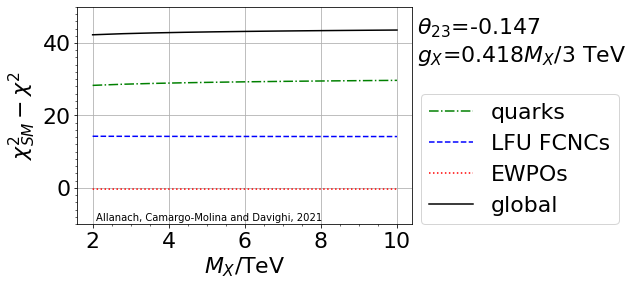

In [23]:
# Plot vs MZp
mzpforplot   = [data['MZp']/1000                        for data in data_for_mzp]
dchi2        = [2 * data['global']                      for data in data_for_mzp]
lfu_dchi2    = [2 * data['likelihood_lfu_fcnc.yaml']    for data in data_for_mzp]
quarks_dchi2 = [2 * data['fast_likelihood_quarks.yaml'] for data in data_for_mzp]
ewpt_dchi2   = [2 * data['likelihood_ewpt.yaml']        for data in data_for_mzp]
fig3, ax3 = plt.subplots()
ax3.set_ylabel('$\chi^2_{SM}-\chi^2$')
ax3.set_xlabel(r'$M_{X}$/TeV') 
ax3.plot(mzpforplot, quarks_dchi2, 'g-.', label='quarks')
ax3.plot(mzpforplot, lfu_dchi2, 'b--', label='LFU FCNCs')
ax3.plot(mzpforplot, ewpt_dchi2, 'r:', label='EWPOs')
ax3.plot(mzpforplot, dchi2, 'k-', label='global')
ax3.legend(loc=[1.025,0]) 
ax3.grid(True) 
ax3.set_ylim([-10, 50])
#plt.gca().set_xlim([0,0.4])
ax3.yaxis.set_minor_locator(plt.MultipleLocator(2))
ax3.xaxis.set_minor_locator(plt.MultipleLocator(0.5))
ax3.text(10.52, 35, r'$\theta_{23}$=' + f'{theta_gf:.3g}' + '\n$g_{X}$=' + f'{gzp_gf:.3g}' + '$M_{X}$/3 TeV')
ax3.text(2.1, -9 , "Allanach, Camargo-Molina and Davighi, 2021", fontsize=10)
fig3.savefig('tfhm_mzp.pdf', bbox_inches = "tight")